## Chargement du jeu de données

In [1]:
from datasets import load_dataset

ds = load_dataset("7Xan7der7/us_airline_sentiment")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 14640/14640 [00:00<00:00, 66080.46 examples/s]


## Conversion du dataset en DataFrame Pandas

In [2]:
df = ds["train"].to_pandas()
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,None,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,None,2/24/2015 11:35,None,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,None,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,None,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,None,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,None,2/24/2015 11:14,None,Pacific Time (US & Canada)


## Analyse initiale du DataFrame

In [3]:
print("nombre of rows")
print(df["text"].count())
print("nombre of null values")
print(df.isnull().sum())
print("nombre of duplicated values")
print(df.duplicated().sum())


nombre of rows
14640
nombre of null values
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
nombre of duplicated values
39


## Sélection des colonnes utiles

In [4]:
df = df[["text","airline_sentiment"]]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## Analyse de la distribution des labels

['neutral' 'positive' 'negative']
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


<Axes: xlabel='airline_sentiment', ylabel='count'>

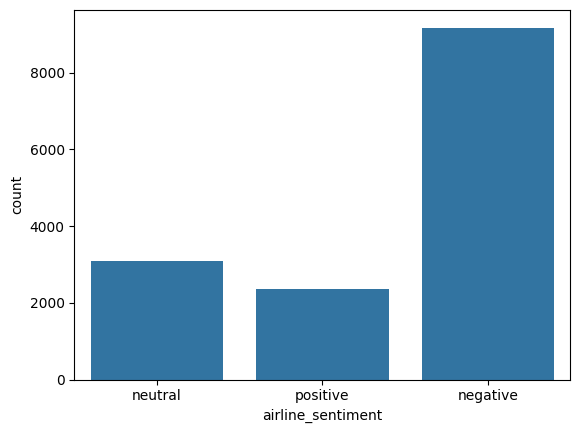

In [5]:
import seaborn as sbn

print(df["airline_sentiment"].unique())
print(df["airline_sentiment"].value_counts())
count_label = df["airline_sentiment"].value_counts()

sbn.countplot(data=df,x="airline_sentiment")

## Distribution de la longueur des textes

count    14640.000000
mean        17.653415
std          6.882259
min          2.000000
25%         12.000000
50%         19.000000
75%         23.000000
max         36.000000
Name: word_count, dtype: float64


<Axes: xlabel='word_count', ylabel='Count'>

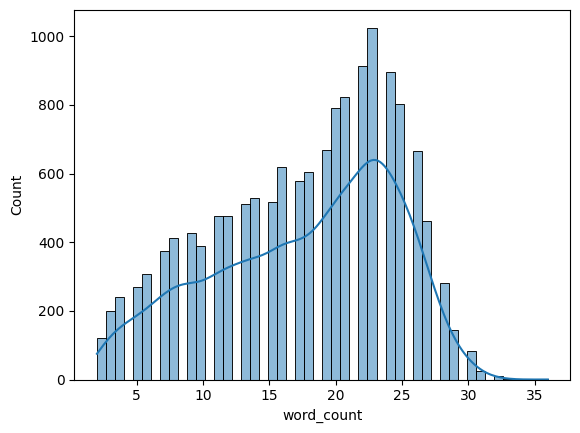

In [6]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print(df["word_count"].describe())

sbn.histplot(df["word_count"],bins=50, kde=True)

## Génération d’un nuage de mots (Word Cloud) par label

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


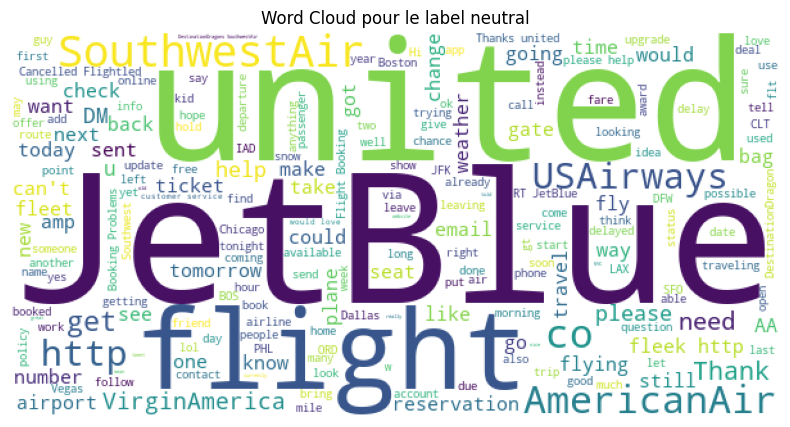

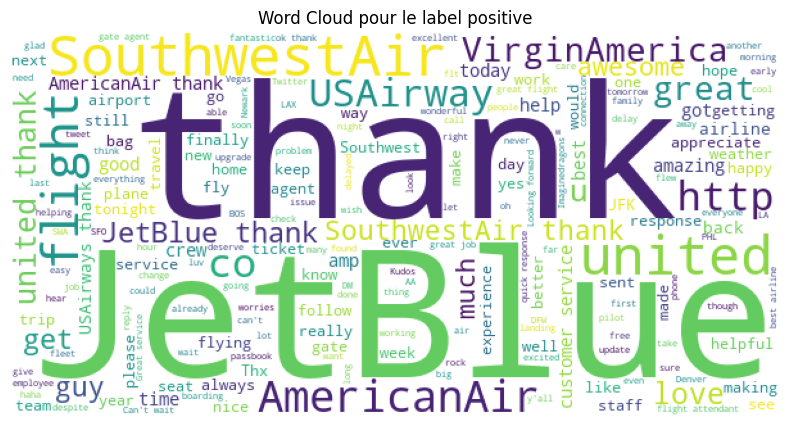

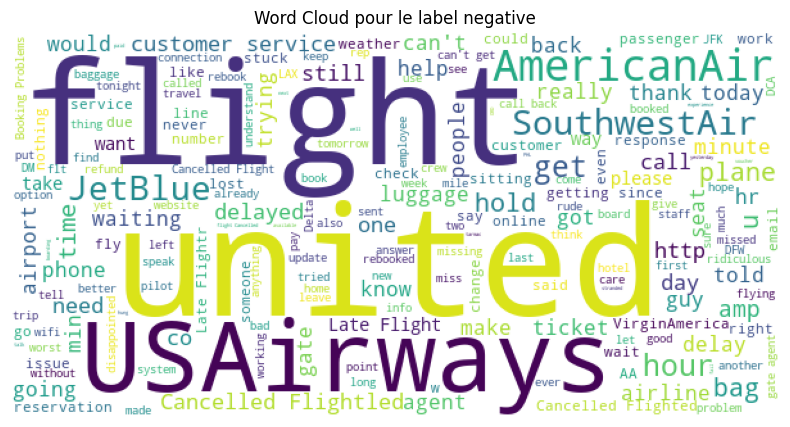

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 
import nltk 
from nltk.corpus import stopwords
labels = df["airline_sentiment"].unique()

nltk.download("stopwords")

for label in labels:
    texts = df[df["airline_sentiment"]==label]["text"]
    combined_text = " ".join(texts)
    wordcloud = WordCloud(
        width=600,
        height=300,
        background_color="white",
        stopwords=set(stopwords.words("english"))
    ).generate(combined_text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud pour le label {label}")
    plt.show()

## Nettoyage et préparation des données textuelles


In [8]:
import pandas as pd
import re

df = df.drop_duplicates()

df = df.dropna(subset=["text"])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Suppression des URLs
    text = re.sub(r"@\w+", "", text)  # Suppression des mentions (@username)
    text = re.sub(r"#\w+", "", text)  # Suppression des hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Suppression de la ponctuation et caractères spéciaux
    text = re.sub(r"\d+", "", text)  # Suppression des chiffres
    text = text.strip()  # Suppression des espaces en début et fin de texte
    return text

df["text_clean"] = df["text"].apply(clean_text)

df.head()


,text,airline_sentiment,word_count,text_clean
0,@VirginAmerica What @dhepburn said.,neutral,4,what said
1,@VirginAmerica plus you've added commercials t...,positive,9,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,12,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,negative,17,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,negative,10,and its a really big bad thing about it


## Normalisation du texte

In [9]:
import re

def normalize_text(text):
    text = text.lower()
    
    text = re.sub(r"\s+", " ", text)
    
    text = text.strip()
    
    return text


## Sauvegarde du jeu de données nettoyé

In [10]:
import os
os.makedirs("data", exist_ok=True)

df = df[["text_clean","airline_sentiment","word_count"]]
df.to_csv("data/clean_data.csv", index=False)